In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(measurement.date)).scalar()
recent_date

'2017-08-23'

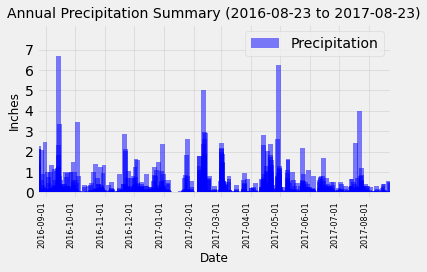

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
previous_date = dt.datetime(2016, 8, 23)

# Perform a query to retrieve the data and precipitation scores
sel = [measurement.date, 
       measurement.prcp]
annual_data = session.query(*sel).filter(measurement.date >= '2016-08-23').all()

# Save the query results as a Pandas DataFrame and set the index to the date column
annual_df = pd.DataFrame(annual_data, columns=['Date', 'Precipitation'])
annual_df.set_index('Date', inplace=True)

# Sort the dataframe by date
sorted_df = annual_df.sort_values("Date")

# Remove NaN values
cleaned_df = sorted_df.dropna()

# Remove index
cleaned_df = cleaned_df.reset_index()

# Process dataset
cleaned_df['Date'] = pd.to_datetime(cleaned_df['Date'])
cleaned_df['Precipitation'] = pd.to_numeric(cleaned_df['Precipitation'])

# Use Pandas plotting with Matplotlib to plot the data
plt.bar(cleaned_df['Date'], cleaned_df['Precipitation'], color="b", alpha=0.5, align="center", width=5)
plt.legend(['Precipitation'], loc="upper right")
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.xticks(rotation="vertical", fontsize=8)
plt.yticks(np.arange(0, 7.1, step=1))
plt.xlim(dt.datetime(2016, 8, 23), dt.datetime(2017, 8, 23))
plt.ylim(-0.25, 8.25)
plt.grid(True, alpha=0.5)
plt.title("Annual Precipitation Summary (2016-08-23 to 2017-08-23)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Inches", fontsize=12)
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to print the summary statistics for the precipitation data.
cleaned_df['Precipitation'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(measurement).group_by(measurement.station).count()
print(stations)

9


In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
stations = session.query(measurement.station, func.count(measurement.station)).\
        group_by(measurement.station).\
        order_by(func.count(measurement.station).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temps = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == 'USC00519281').all()
temps

[(54.0, 85.0, 71.66378066378067)]

In [15]:
# Find the most recent date in the data set for station USC00519281
recent_date = session.query(func.max(measurement.date)).filter(measurement.station == 'USC00519281').scalar()
recent_date

'2017-08-18'

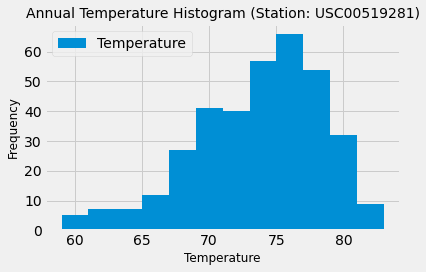

In [16]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
previous_date = dt.datetime(2016, 8, 18)

# Perform a query to retrieve the date and temperature scores
sel = [measurement.date, 
       measurement.tobs]
annual_data = session.query(*sel).filter(measurement.station == 'USC00519281').\
    filter(measurement.date >= '2016-08-18').all()

# Save the query results as a Pandas DataFrame and set the index to the date column
annual_df = pd.DataFrame(annual_data, columns=['Date', 'Temperature'])
annual_df.set_index('Date', inplace=True)

# Sort the dataframe by date
sorted_df = annual_df.sort_values("Date")

# Remove NaN values
cleaned_df = sorted_df.dropna()

# Process dataset
temps = cleaned_df["Temperature"]

# Use Pandas plotting with Matplotlib to plot the histogram
plt.hist(temps, bins=12)
plt.legend(['Temperature'], loc="upper left")
plt.title("Annual Temperature Histogram (Station: USC00519281)", fontsize=14)
plt.xlabel('Temperature', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

# Close session

In [17]:
# Close Session
session.close()